# **Roadmap Overview**
	Step 1: Data Preparation

	Step 2: Feature Extraction with EfficientNetB0

	Step 3: Train the Attribute Prediction Model

	Step 4: Zero-Shot Classification
  
	Step 5: Evaluation




# Data Preparation

**Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D, Flatten,Input,Dropout,BatchNormalization,Rescaling,GlobalAveragePooling2D


from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

**Loading Data**

In [ ]:
data = image_dataset_from_directory(                                            # creating a tensorflow.data.dataset to store the data
    '/kaggle/input/vlg-recruitment-24-challenge/vlg-dataset/vlg-dataset/train',
    batch_size=None,                                                            # didn't go for batching since batched data can cause difficulties while splitting
    label_mode='int',                                                           # assigning labels as integers corresponging to class
    seed=42
)

Found 9544 files belonging to 40 classes.


In [ ]:
labels=data.class_names                                                         # fetch the class-names of all the classes from the sub-folders of the directory
labelled_classes = {index: name for index, name in enumerate(labels)}           # mapping the class-names and label in a dictionary

**Importing the csv file and mapping a dictionary**

In [ ]:
df=pd.read_csv('/kaggle/input/final-embeddings-list/normalized_predicate_matrix.csv') # importing predicate matrix

col_names=[]                                                                    # making a list to contain all the collumn names
col_names.append("Classes")
for i in range (1,86):                                                          # naming the nth feature as dim{n}
    col_names.append(f'dim{i}')
df.columns=col_names                                                            # changing the column names with the use of col_names list

df_columns = [f"dim{i}" for i in range(1, 86)]                                  # making a list of all feature columns
df['embedding'] = df[df_columns].values.tolist()                                # creating a new column which contains the list of all features in one column itself
for i in range(1,86):
    df=df.drop(f'dim{i}',axis=1)                                                # dropping all the columns containg seprate features

In [ ]:
attribute_embeddings=df.set_index('Classes')['embedding'].to_dict()             # mapping a dictionary containing the names of each class along with their attribute embeddings

**Transforming int labels to embeddings labels**

In [ ]:
def embedding_vectors(image, label):                                            # function to change the int labels of dataset to attribute embeddings
                                                                                # Map label to class name and then to embedding vector
    class_name = labelled_classes[label.numpy()]                                # Convert to numpy to use as index
    embedding_vector = attribute_embeddings[class_name]

    # Ensure embedding_vector is a TensorFlow tensor
    embedding_vector = tf.convert_to_tensor(embedding_vector, dtype=tf.float32) # converting embedding vector to tensor for a better compatibility

    return image, embedding_vector



def embedding_vectors_with_shape(image, label):
    image, embedding_vector = tf.py_function(                                   # using py.function to simply
        func=embedding_vectors,
        inp=[image, label],
        Tout=(tf.float32, tf.float32)
    )

    image.set_shape([None, None, 3])                                            # keeping the actual image size
    embedding_vector.set_shape([85])
    return image, embedding_vector

data = data.map(embedding_vectors_with_shape)                                   # mapping the function into dataset


**Image preprocessing**

In [ ]:
def img_process(image,label):                                                   # making image ready to go to model
    image=tf.image.resize(image,[224,224])                                      # this is the standard input size for efficient net model
    image=preprocess_input(image)                                               # this function normalises the pixel values as per efficient net
    return image,label

data=data.map(img_process, num_parallel_calls=tf.data.AUTOTUNE)                 # mapping the function into dataset

**Splitting of Data**

In [ ]:
size = data.cardinality().numpy()                                               # extracting size of dataset
train_size=int(size*0.8)                                                        # 80% for train set
cross_size=int(size-train_size)                                                 # 20% for cross-validation set
shuffled_data=data.shuffle(buffer_size=size,seed=42)                            # shuffling data
train_data=shuffled_data.take(train_size)                                       # taking the first 80% of shuffled data set to train-set
cross_data=shuffled_data.skip(train_size).take(cross_size)                      # rest 20% for validation-set

train_data=train_data.batch(128)                                                # batching the train and validation data
cross_data=cross_data.batch(128)

**Data augmentation**

In [ ]:
data_aug = Sequential([                                                         # pipeline for data augmentation
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.2, 0.2)
])

def apply_augmentation(image, label):                                           # function to apply the augmentation pipeline
    image = data_aug(image, training=False)
    return image, label

train_data = train_data.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)  # mapping the augmentation function to train data

# Feature Extraction with EfficientNetB0

**Loading Base EfficientNet Model**

In [ ]:
base_model = EfficientNetB0(                                                    # loading efficient net as base model
    weights='imagenet',                                                         # loading the pre-trained weights
    include_top=False,                                                          # not including the classification layer
    input_shape=(224, 224, 3)                                                   # defining the input shape
)

base_model.trainable = False                                                    # currently making the base model non-trainable

model = Sequential([                                                            # creating the main model
    base_model,
    GlobalAveragePooling2D(),                                                   # adding hidden layer
    Dense(85, activation='relu')                                                # output layer which yields the vector embeddings
])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Custom made loss function**

In [ ]:
def weighted_mse(y_true, y_pred, weights):                                      # this loss function is a weighted mean squared error loss function

    # Calculate squared errors
    weights = tf.cast(weights, y_true.dtype)                                    # casting the weights vector into same type as the attribute embedding
    squared_errors = tf.square(y_true - y_pred)                                 # calculating squared error
    # Apply weights
    weighted_squared_errors = weights * squared_errors                          # calculating weighted square error by element wise multiplication

    # Normalize by the sum of weights
    loss = tf.reduce_sum(weighted_squared_errors) / tf.reduce_sum(weights)      # calculating mean squared error
    return loss                                                                 # returning loss

def weighted_mse_loss(weights):                                                 # simplifying the arguments of the loss function
    def loss(y_true, y_pred):
        return weighted_mse(y_true, y_pred, weights)
    return loss

Weights are assigned to each feature as per their variance 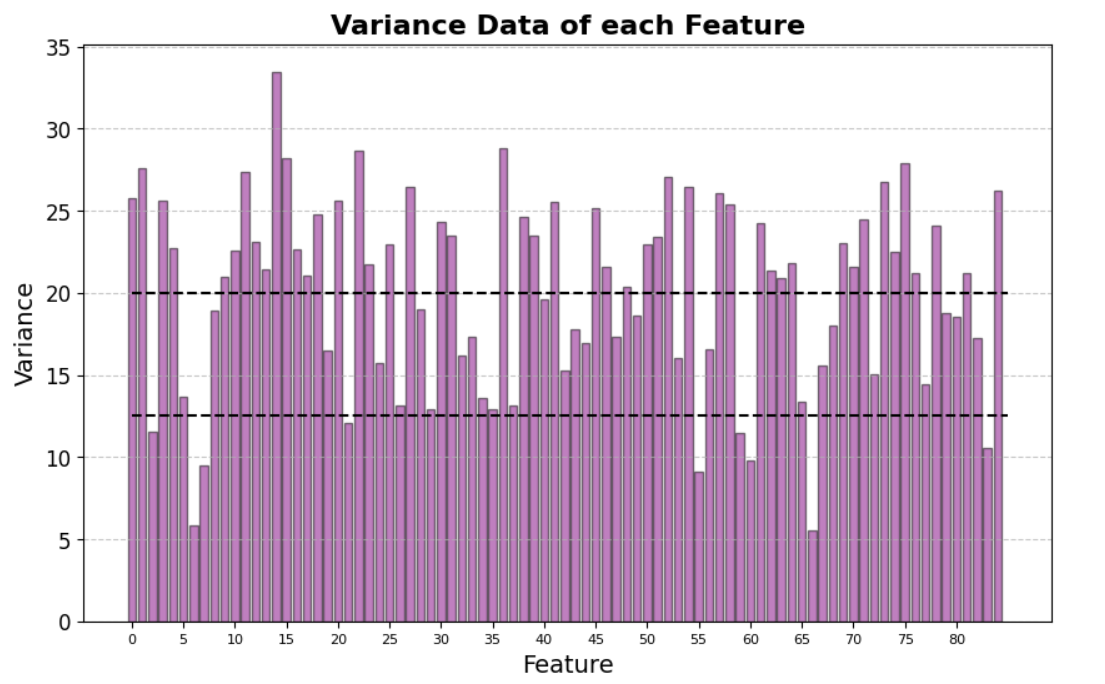

features having variance lower than 12.5 are categorised as low and features having higher variance than 20 are categorised as high

In [ ]:
weights=np.ones(85)
high=[ 0,  1,  3,  4,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23,
       25, 27, 30, 31, 36, 38, 39, 41, 45, 46, 48, 50, 51, 52, 54, 57, 58,
       61, 62, 63, 64, 69, 70, 71, 73, 74, 75, 76, 78, 81, 84]
low=[ 2,  6,  7, 21, 55, 59, 60, 66, 83]

weights=np.ones(85)                                                             # creating a weight vector of 1's
weights[high]=1.75                                                              # 'high' importance features have their weights increased to 1.75
weights[low]=0.5                                                                # 'low' importance features have their weights decreased to 0.5

# Train the attribute prediction model

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:100]:                                           # Fine-tune layers from the 100th layer onwards
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),           # Re-compiling the model with a lower learning rate for fine-tuning
              loss=weighted_mse_loss(weights))

early_stop=EarlyStopping(                                                       # implementing early stopping callback to prevent overfitting and excessive computation
    monitor='val_loss',                                                         # having check on validation loss
    restore_best_weights=True,
    patience=5,
    min_delta=1e-4,
)
history=model.fit(train_data, validation_data=cross_data, epochs=40, callbacks=[early_stop]) # training (fine tuning) the model

Epoch 1/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - loss: 125.6085 - val_loss: 90.1849
Epoch 2/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 807ms/step - loss: 83.9787 - val_loss: 70.8123
Epoch 3/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 813ms/step - loss: 69.1288 - val_loss: 62.1129
Epoch 4/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 813ms/step - loss: 62.7806 - val_loss: 56.7204
Epoch 5/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 803ms/step - loss: 59.2149 - val_loss: 54.7308
Epoch 6/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 802ms/step - loss: 56.2182 - val_loss: 52.0988
Epoch 7/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 807ms/step - loss: 54.6045 - val_loss: 50.7623
Epoch 8/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 805ms/step - loss: 52.3971 - val_loss: 49.9328
Epoch 9/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 804ms/step - loss: 52.0990 - val_loss: 49.0305
Epoch 10/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 805ms/step - loss: 50.7996 - val_loss: 48.3833
Epoch 11/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 804ms/step - loss: 50.3415 - val_loss: 46.4545
Epoch 12/40
60/60 ━━

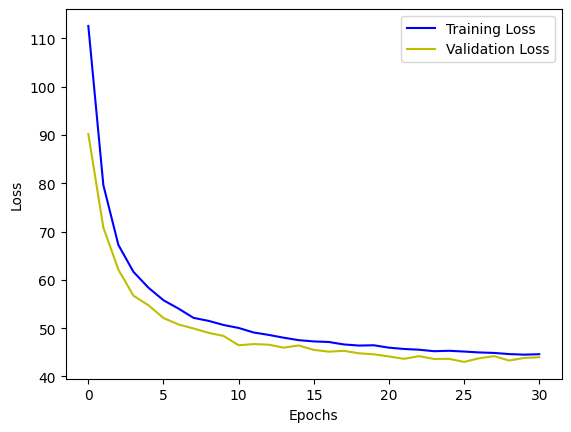

In [ ]:
plt.plot(history.history['loss'], label='Training Loss',color='b')              # plotting loss curves for training and validation set
plt.plot(history.history['val_loss'], label='Validation Loss',color='y')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Zero Shot Classification

In [ ]:
from scipy.spatial.distance import cosine                                       # importing cosine similarity


def predict_class(image_batch,model,attribute_embeddings):                      # class_attributes is the attribute vector for each class (both seen and unseen)

    similarities = {}                                                           # creating a dictionary
    predicted_attributes=model.predict(image_batch)                             # predicted_attributes is the predicted vector for a test image
    batch_pred=[]
    for each_attribute in predicted_attributes:                                 # this is executed on a batch to iterate through each predicted attribute of that batch
        for class_name, class_attributes in attribute_embeddings.items():
            similarity = cosine(each_attribute, class_attributes)               # calculating similarity
            similarities[class_name] = similarity                               # storing the similarity along with the class name in a dictionary

        sorted_classes = sorted(similarities, key=similarities.get)             # Sort by similarity (lowest cosine distance means highest similarity)
        batch_pred.append(sorted_classes[0])                                    # Most similar class

    return  (batch_pred)                                                        # returning a list of string containg the predicted class names for each image of a batch


# Evaluation

In [ ]:
import os                                                                       # importing essential libraries
import pandas as pd


# Path to the test dataset
test_dir = '/kaggle/input/vlg-recruitment-24-challenge/vlg-dataset/vlg-dataset/test' # test directory

# List of image file paths (assuming all images are in the same directory)
image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith('.jpg')] #storing the path of all images in a list

def load_and_preprocess_image(image_path):                                      # Function to load and preprocess images
    image = tf.io.read_file(image_path)                                         # image is read from image path
    image = tf.image.decode_jpeg(image, channels=3)                             # converting image into pixel values
    image = tf.image.resize(image, (224, 224))                                  # Resize to the input size of the model
    image = preprocess_input(image)
    return image

images = [load_and_preprocess_image(path) for path in image_paths]              # Load and preprocess all images

batch_size = 64                                                                 # Creating a batched dataset
image_dataset = tf.data.Dataset.from_tensor_slices(images)
image_dataset = image_dataset.batch(batch_size)


predictions = []                                                                # Create a list to store predictions


for image_batch in image_dataset:                                               # Iterate through batches of images
    predictions.extend(predict_class(image_batch,model,attribute_embeddings))   # using the predict_class function that was defined earlier and storing the predictions in the 'predictions' list

results = {                                                                     # creating a dictionary to store the image path(names) and their predicted labels
    'image': [os.path.basename(path) for path in image_paths],                  # Using image_paths lisst
    'label': predictions                                                        # predictions list
}

df = pd.DataFrame(results)                                                      # Creating a DataFrame from the dictionary
df.columns=['image_id','class']                                                 # changing the column names
df=df.sort_values('image_id')                                                   # sorting according to image names
df.to_csv('output_test_set.csv', index=False)                                   # dataframe saved to csv

print("Predictions saved to 'output_test_set.csv'")


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━

In [ ]:
# using the same code as earlier to evaluate on special package
import os
import pandas as pd

test_dir = '/kaggle/input/vlg-recruitment-24-challenge/Special-Package/Special-Package/final_examples'

image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith('.png')]

def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)                              # since the special package images are in png format
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)
    return image

images = [load_and_preprocess_image(path) for path in image_paths]

batch_size = 64
image_dataset = tf.data.Dataset.from_tensor_slices(images)
image_dataset = image_dataset.batch(batch_size)

predictions = []

for image_batch in image_dataset:
    predictions.extend(predict_class(image_batch,model,attribute_embeddings))


results = {
    'image': [os.path.basename(path) for path in image_paths],
    'label': predictions
}

df = pd.DataFrame(results)
df.columns=['image_id','class']
df=df.sort_values('image_id')
df.to_csv('specail_package.csv', index=False)

print("Predictions saved to 'special_package.csv'")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step 
Predictions saved to 'output.csv'
